In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
from geopy import distance
import requests
import json
import datetime
import math
import itertools
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from pulp import *
import seaborn as sn
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

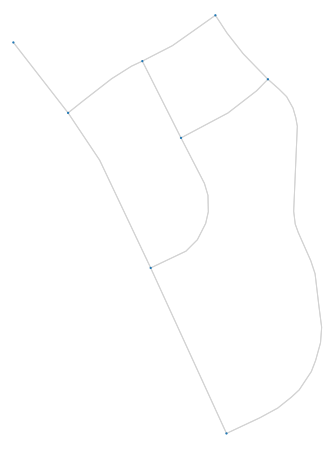

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [2]:
east, north, west, south = -78.815266,35.565956,-78.810330,35.571541

#north, south, east, west = 35.588654,35.591812,-78.808848,-78.806101
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)

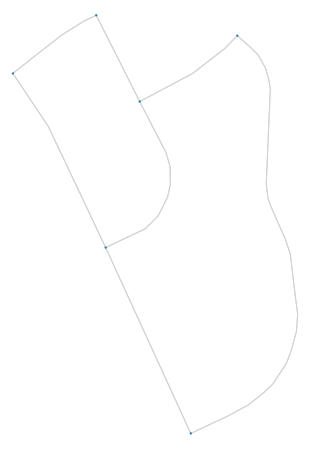

In [3]:

#Creating a bounding box
east, north, west, south = -78.814231,35.566406,-78.810755,35.570595    
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ox.plot.plot_graph(G, bgcolor='#FFFFFF', node_color=colors[0], edge_color='lightgray', node_size=5)


    #Extracting Node Information from G
Nodes = []
for i in G.nodes:
    Nodes.append(i)

data = pd.DataFrame(Nodes)
data.rename(columns = {0:'Nodes'}, inplace = True)
G = ox.graph_from_place('Fuquay Varina, NC, USA', network_type='drive')

lat1 = []
long1 = []
for i in Nodes:
    lat1.append(G.nodes[i].get('y'))
    long1.append(G.nodes[i].get('x'))
data['Latitude'] = lat1
data['Longitude'] = long1
df1 = data

df1 = df1.drop(['Nodes'],axis=1)
df1.rename(columns = {'Latitude':'Left'}, inplace = True)
df1.rename(columns = {'Longitude':'Right'}, inplace = True)

    #Calculating Distance and the distance matrix for all coordinates in the Bounding Box
df3 = pd.DataFrame()
for j in df1.index:
    list1 = []
    for i in df1.index:
        r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{df1.loc[j, "Right"]},{df1.loc[j, "Left"]};{df1.loc[i, "Right"]},{df1.loc[i, "Left"]}?overview=false""")
        list1.append(json.loads(r.content)["routes"][0]["distance"])
    df3[j] = list1
df = df1
df['coordinate'] = list(zip(df['Right'],df['Left']))
df['ID'] = df.index

locations = dict( ( ID, (df.loc[ID, 'Right'], df.loc[ID, 'Left']) ) for ID in df.index)
distances_df = df3
distance = distances_df
distances = dict( ((l1,l2), distance.iloc[l1, l2] ) for l1 in locations for l2 in locations if l1!=l2)


    ## V: This defines the total number of vehicles that will traverse the path.
V = 1
    ## prob: This initializes the problem that will run using provided constraints.

prob=LpProblem("vehicle", LpMinimize)
    ## indicator: This defines the variable dictionary consisting of distances and indicates if location i is connected to location j along route
indicator = LpVariable.dicts('indicator',distances, 0,1,LpBinary)
    ## eliminator: This defines the variable dictionary consisting of the node ID's and elimiate subtours
eliminator = LpVariable.dicts('eliminator', df.ID, 0, len(df.ID)-1, LpInteger)
    ## cost: This stores the result of distances calculations.
cost = lpSum([indicator[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

start1 = 2
for v in df.ID:
        ## cap: This considers a particular node at a time. 
    cap = 1 if v != start1 else V
        #inward possible route
    prob+= lpSum([ indicator[(i,v)] for i in df.ID if (i,v) in indicator]) ==cap
        #outward possible route
    prob+=lpSum([ indicator[(v,i)] for i in df.ID if (v,i) in indicator]) ==cap
    ## num: This stores the result of the number of nodes and the number of vehicles.    
num=len(df.ID)/V
for i in df.ID:
    for j in df.ID:
        if i != j and (i != start1 and j!= start1) and (i,j) in indicator:
             prob += eliminator[i] - eliminator[j] <= (num)*(1-indicator[(i,j)]) - 1         
prob.solve()
    ## feasibleedges: This stores values of edges after the calculations are done.
feasible_edges = [ e for e in indicator if value(indicator[e]) != 0 ]
    ##@get_next_loc
    # This provides with the next coordinates for the next node in the path.
def get_next_loc(initial):
    edges = [e for e in feasible_edges if e[0]==initial]
    for e in edges:
        feasible_edges.remove(e)
    return edges
    ## routes: This stores information regarding paths.    
routes = get_next_loc(2)
routes = [ [e] for e in routes ]

for r in routes:
    while r[-1][1] !=start1:
        r.append(get_next_loc(r[-1][1])[-1])




df2 = df[['Left', 'Right', 'ID']].copy()
df2.rename(columns = {'Left':'Latitude'}, inplace = True)
df2.rename(columns = {'Right':'Longitude'}, inplace = True)
a=[]
for i in range(data.index.stop):
    #print(routes[0][i][0])
    a.append(routes[0][i][0]) 

    
    
df3 = pd.DataFrame()
for i in a:
    df3 = df3.append(df2.loc[i])

df3.reset_index(inplace = True)

df3 = df3.append(df3.loc[0])
df3.reset_index(inplace = True)
long2 = [] 
lat2 = []  
for i in df3.index:
    long2.append(df3.loc[i]["Longitude"])
    lat2.append(df3.loc[i]["Latitude"])
df4 = df3
dfnodes = pd.DataFrame(Nodes)
dfnodes.rename(columns = {0:'Nodes'}, inplace = True)
dfnodes = dfnodes.reindex(a)
dfnodes = dfnodes.append({"Nodes":Nodes[a[0]]},ignore_index=True)
df4 = pd.concat([df4,dfnodes],axis=1)
pathlist = []
 
for i in range(df4['Nodes'].count()-1):
    path1 = nx.shortest_path(G, df4.iloc[i]['Nodes'],df4.iloc[i+1]['Nodes'], weight='travel_time')
    pathlist = pathlist+path1
pathlist1 = list(dict.fromkeys(pathlist))
pathlist1.append(pathlist1[0])
data4 = pd.DataFrame(pathlist1)
data4.rename(columns = {0:'Nodes'}, inplace = True)
lat1 = []
long1 = []
def plot_path(lat, long, origin_point, destination_point):
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'grey')))
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    fig.update_layout(mapbox_style="carto-darkmatter",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                        mapbox = {
                            'center': {'lat': lat_center, 
                            'lon': long_center},
                            'zoom': 13})
    fig.show()


origin_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"]) 
destination_point2 = (df3.loc[0]["Latitude"], df3.loc[0]["Longitude"])
plot_path(lat2, long2, origin_point2, destination_point2)



In [4]:
pathlist1

[1278913066.0,
 1278913077,
 1278913206,
 1278912898,
 1278913064,
 1278913223,
 1278913066.0]

In [5]:
node1 = pathlist1[4]

In [6]:
node2 = pathlist1[5]

In [7]:
G.edges(data=True)

OutMultiEdgeDataView([(195387309, 6845821020, {'osmid': 18888160, 'highway': 'residential', 'oneway': False, 'length': 86.95, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001FC968A1CA0>}), (195387309, 3921480296, {'osmid': 18913578, 'name': 'Windsor Wynd Place', 'highway': 'residential', 'oneway': False, 'length': 326.023, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001FC968A1C40>}), (195387309, 5671027942, {'osmid': 594799369, 'highway': 'residential', 'oneway': False, 'length': 183.08500000000004, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001FC968A1BB0>}), (195387404, 195387408, {'osmid': 18888171, 'name': 'Tansea Court', 'highway': 'residential', 'oneway': False, 'length': 132.226, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001FC908BFBB0>}), (195387404, 1245037431, {'osmid': 18888171, 'name': 'Tansea Court', 'highway': 'residential', 'oneway': False, 'length': 106.62599999999999, 'geometry'

In [8]:
z = []  
for i in list(G.edges(data=True)):
     if (i[0]==node1) & (i[1]==node2):
        z.append(i)

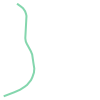

In [9]:
z[0][2]['geometry']

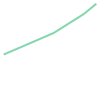

In [10]:
node1 = pathlist1[3]
node2 = pathlist1[4]
z = []  
for i in list(G.edges(data=True)):
     if (i[0]==node1) & (i[1]==node2):
        z.append(i)
z[0][2]['geometry']        

In [11]:
z

[(1278912898,
  1278913064,
  {'osmid': 112548336,
   'name': 'Ponymill Way',
   'highway': 'residential',
   'maxspeed': '25 mph',
   'oneway': False,
   'length': 118.252,
   'geometry': <shapely.geometry.linestring.LineString at 0x1fc994e8310>})]

In [12]:
def node_list_to_path(G, node_list):
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        data = min(G.get_edge_data(u, v).values(), 
                   key=lambda x: x['length'])
        if 'geometry' in data:
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)    
    return lines

In [13]:
pathlist1

[1278913066.0,
 1278913077,
 1278913206,
 1278912898,
 1278913064,
 1278913223,
 1278913066.0]

In [14]:
lines = node_list_to_path(G, pathlist1)

In [15]:
long2 = []
lat2 = []

In [16]:
for i in range(len(lines)):
    z = list(lines[i])
    l1 = list(list(zip(*z))[0])
    l2 = list(list(zip(*z))[1])
    for j in range(len(l1)):
        long2.append(l1[j])
        lat2.append(l2[j])

In [17]:
plot_path(lat2, long2, origin_point2, destination_point2)

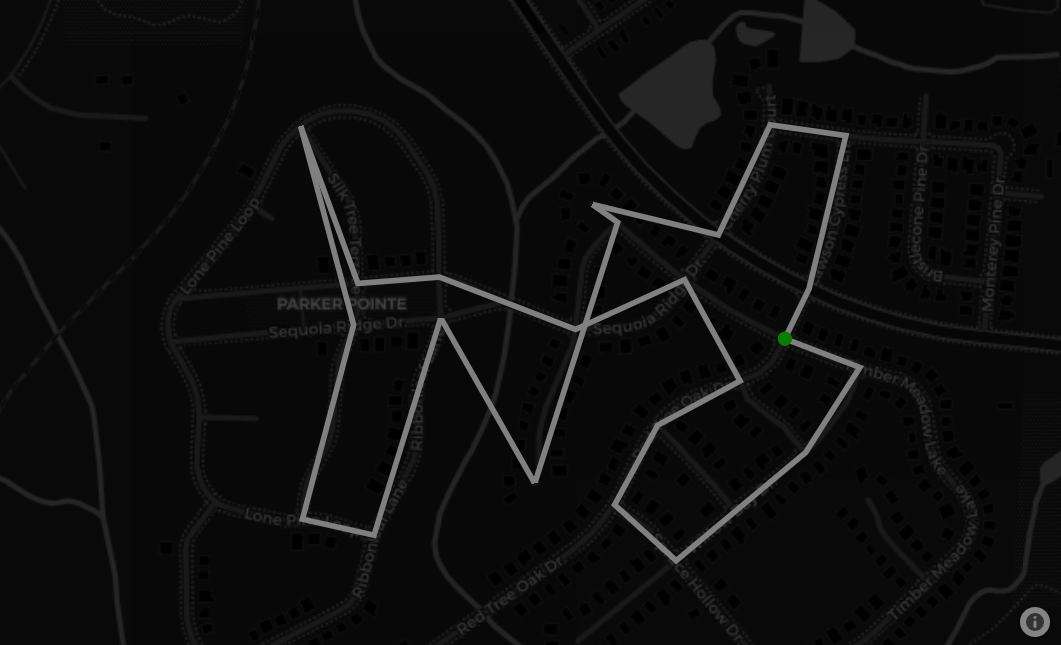

In [1]:
from IPython.display import Image
Image(filename = "WrongPath1.png", width = 600, height = 300)

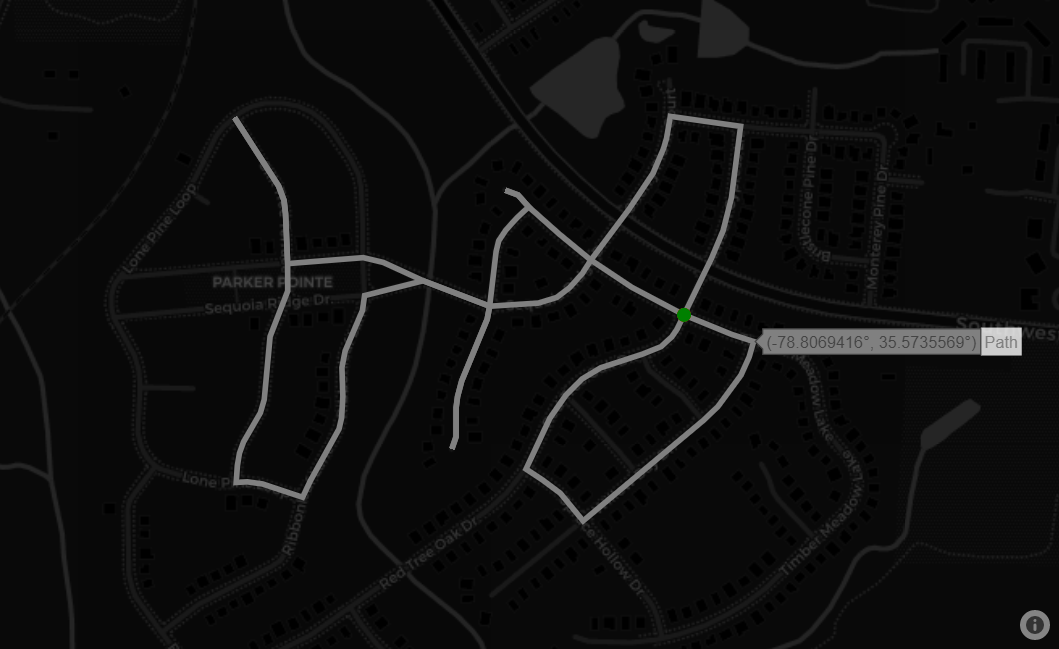

In [2]:
from IPython.display import Image
Image(filename = "CorrectPath1.png", width = 600, height = 300)

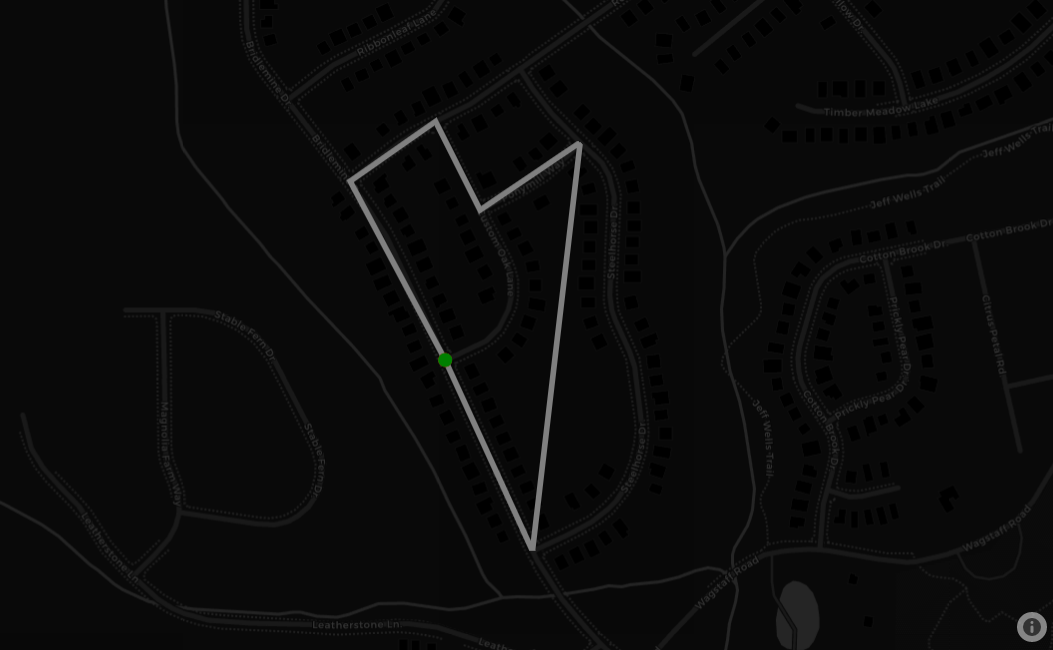

In [3]:
from IPython.display import Image
Image(filename = "WrongPath2.png", width = 600, height = 300)

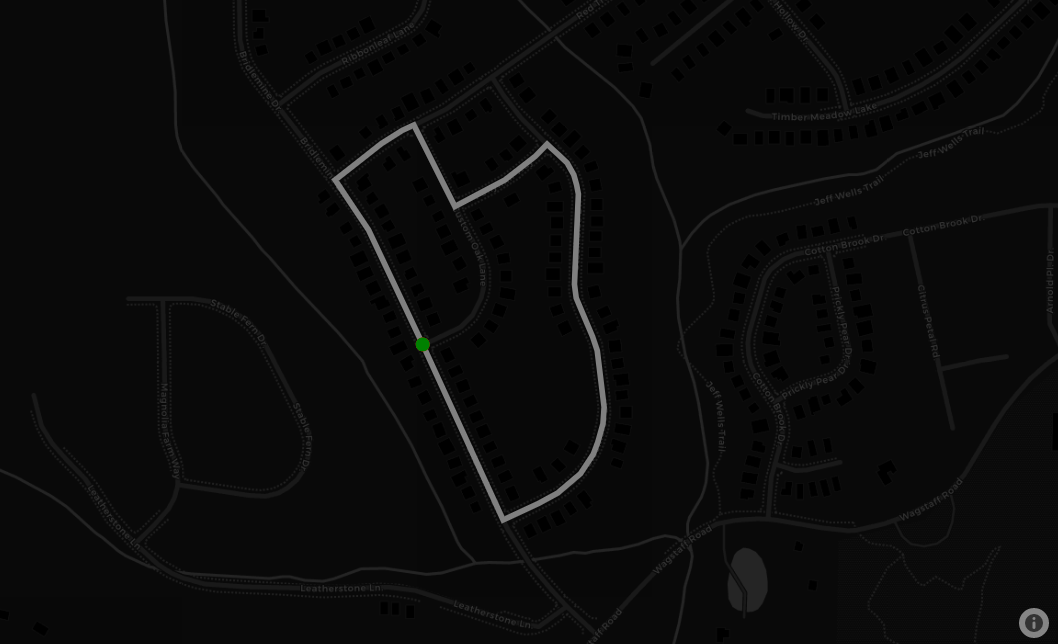

In [4]:
from IPython.display import Image
Image(filename = "CorrectPath2.png", width = 600, height = 300)